# RAG

Setting up environment and validating the required environment variables.

In [1]:
from pydantic_settings import BaseSettings, SettingsConfigDict


class Settings(BaseSettings):
    model_config = SettingsConfigDict(extra="ignore")

    openai_api_key: str
    database_path: str = "./data"


settings = Settings()

Setting up embeddings and vector store.

In [2]:
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
vector_store = Chroma(
    collection_name="docs",
    embedding_function=embeddings,
    persist_directory=settings.database_path,
)
documents = [
    Document(
        page_content="LangChain is a framework for building applications with LLMs.",
        id="1",
    ),
    Document(page_content="RAG stands for Retrieval-Augmented Generation.", id="2"),
    Document(
        page_content="FAISS is Facebook AI Similarity Search for vector indexing.",
        id="3",
    ),
]
ids = list(map(lambda doc: doc.id, documents))
_ = vector_store.add_documents(documents=documents, ids=ids)

In [3]:
# from langchain.retrievers.self_query.base import SelfQueryRetriever
# from langchain_openai import OpenAI

# document_content_description = "Topics related to RAG"
# llm = OpenAI(temperature=0)
# retriever = SelfQueryRetriever.from_llm(
#     llm, vector_store, document_content_description, [], enable_limit=True, verbose=True
# )

# retriever.invoke("What is LangChain?")

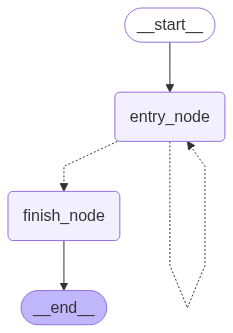

In [4]:
from typing import Literal, TypedDict

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langgraph.graph.state import StateGraph
from langgraph.types import Command as LanggraphCommand
from pydantic import BaseModel

GraphNodes = Literal["entry_node", "finish_node"]
GraphCommand = LanggraphCommand[GraphNodes]


class GraphConfig(TypedDict): ...


class GraphState(BaseModel): ...


agent = init_chat_model("gpt-4o-mini", model_provider="openai")


def entry_node(state: GraphState) -> GraphCommand:
    return GraphCommand(update=state, goto="finish_node")


def finish_node(state: GraphState) -> GraphState:
    return state


graph = (
    StateGraph(GraphState, config_schema=GraphConfig)
    .add_node(entry_node)
    .add_node(finish_node)
    .set_entry_point("entry_node")
    .set_finish_point("finish_node")
    .compile()
)
display(Image(graph.get_graph().draw_mermaid_png()))